In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import express

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader

from transformers import DistilBertTokenizer, DistilBertModel

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

In [3]:
data_dir = "/kaggle/input/it-service-ticket-classification-dataset/all_tickets_processed_improved_v3.csv"

In [4]:
df = pd.read_csv(data_dir)
df

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous
...,...,...
47832,git space for a project issues with adding use...,Access
47833,error sent july error hi guys can you help out...,Miscellaneous
47834,connection issues sent tuesday july connection...,Hardware
47835,error cube reports sent tuesday july error hel...,HR Support


In [5]:
df = df.rename(columns={"Document":"text", "Topic_group":"label"})
df

,text,label
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous
...,...,...
47832,git space for a project issues with adding use...,Access
47833,error sent july error hi guys can you help out...,Miscellaneous
47834,connection issues sent tuesday july connection...,Hardware
47835,error cube reports sent tuesday july error hel...,HR Support


In [6]:
value_counts = df.label.value_counts()
value_counts

label
Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1760
Name: count, dtype: int64

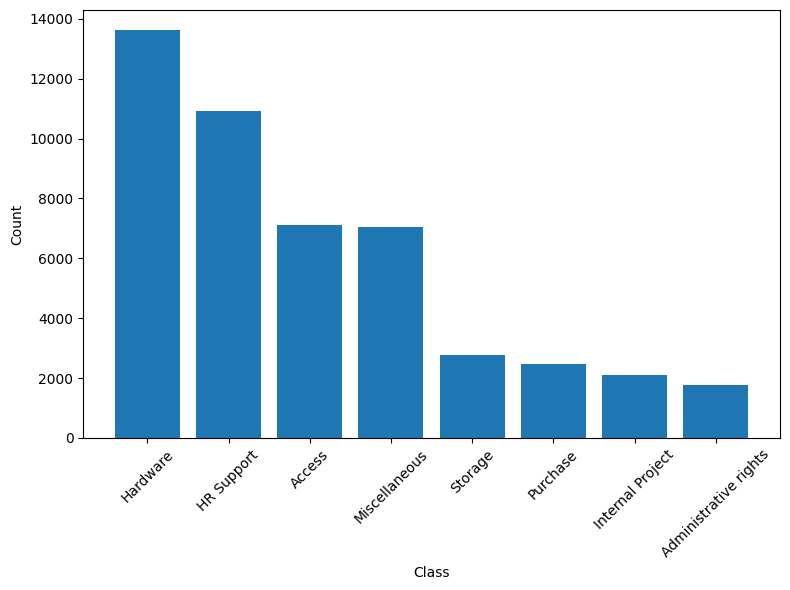

In [7]:
plt.figure(figsize=(8,6))
plt.bar(value_counts.keys(), value_counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()

In [8]:
express.pie(data_frame=df, names=df.label, color=df.label)

In [9]:
express.histogram(data_frame=df.text.str.len(), log_y=True)

In [10]:
le = LabelEncoder()

df.label = le.fit_transform(df.label)
df

,text,label
0,connection with icon icon dear please setup ic...,3
1,work experience user work experience user hi w...,0
2,requesting for meeting requesting meeting hi p...,3
3,reset passwords for external accounts re expir...,0
4,mail verification warning hi has got attached ...,5
...,...,...
47832,git space for a project issues with adding use...,0
47833,error sent july error hi guys can you help out...,5
47834,connection issues sent tuesday july connection...,3
47835,error cube reports sent tuesday july error hel...,2


In [11]:
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=42)

len(train_data), len(test_data), len(val_data)

(38269, 4784, 4784)

In [12]:
#train_data, temp_data = train_test_split(sub_train, test_size=0.2, random_state=42)
#test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=42)

#len(train_data), len(test_data), len(val_data)

In [13]:
tokenizer_distil = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [14]:
train_encodings = tokenizer_distil(train_data["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
test_encodings = tokenizer_distil(test_data["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
val_encodings = tokenizer_distil(val_data["text"].tolist(), padding=True, truncation=True, return_tensors="pt")

In [15]:
train_ds = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], torch.tensor(train_data["label"].values))
test_ds = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], torch.tensor(test_data["label"].values))
val_ds = TensorDataset(val_encodings["input_ids"], val_encodings["attention_mask"], torch.tensor(val_data["label"].values))

In [16]:
BATCH = 32

train_dl = DataLoader(train_ds, BATCH, shuffle=True)
test_dl = DataLoader(test_ds, BATCH)
val_dl = DataLoader(val_ds, BATCH)

In [17]:
for batch in train_dl:
    print(batch)
    
    break

[tensor([[  101,  5080,  9499,  ...,     0,     0,     0],
        [  101,  2047,  2622,  ...,     0,     0,     0],
        [  101,  6140, 11727,  ...,     0,     0,     0],
        ...,
        [  101,  2047,  5309,  ...,     0,     0,     0],
        [  101,  4187,  9499,  ...,     0,     0,     0],
        [  101,  3319,  9344,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([5, 4, 2, 7, 3, 5, 2, 6, 5, 2, 5, 7, 2, 3, 2, 0, 5, 5, 2, 0, 0, 5, 5, 5,
        6, 1, 1, 4, 0, 6, 3, 3])]


In [18]:
num_classes = len(value_counts)
num_classes

8

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [20]:
distil_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

for param in distil_model.parameters():
    param.require_grad = False

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [21]:
class CustomClassifier(nn.Module):
    def __init__(self, distilbert_model, hidden_size, num_classes):
        super(CustomClassifier, self).__init__()
        self.distilbert = distilbert_model
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  
        
        logits = self.classifier(pooled_output)
        return logits

In [22]:
model = CustomClassifier(distil_model, distil_model.config.hidden_size, num_classes)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.classifier.parameters(),
                             lr=1e-3)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [24]:
EPOCHS = 15

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler):
    model.to(device)
    
    train_losses = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for batch in train_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        epoch_loss = running_loss / len(train_data)
        train_losses.append(epoch_loss)
        
        model.eval()
        running_loss_val = 0.0
        correct = 0
        total = 0
        
        with torch.inference_mode():
              
            for batch in val_loader:
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)
            
                optimizer.zero_grad()
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                running_loss_val += loss.item()
            
                _, preds = torch.max(logits, dim=1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        
        val_loss = running_loss_val / len(val_loader)
        val_losses.append(val_loss)
        val_acc = correct / total
        val_accs.append(val_acc)
        
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {epoch_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc*100:.4f}%")
              
    return model, train_losses, val_losses, val_accs


In [25]:
trained_model, train_losses, val_losses, val_accs = train_model(model, train_dl, val_dl, criterion, optimizer, EPOCHS, scheduler)

Epoch 1/15
Training Loss: 0.0379
Validation Loss: 0.9055, Validation Accuracy: 67.2032%
Epoch 2/15
Training Loss: 0.0306
Validation Loss: 0.8988, Validation Accuracy: 67.7258%
Epoch 3/15
Training Loss: 0.0287
Validation Loss: 0.7913, Validation Accuracy: 71.8436%
Epoch 4/15
Training Loss: 0.0258
Validation Loss: 0.7329, Validation Accuracy: 74.3311%
Epoch 5/15
Training Loss: 0.0252
Validation Loss: 0.7218, Validation Accuracy: 74.5401%
Epoch 6/15
Training Loss: 0.0248
Validation Loss: 0.7201, Validation Accuracy: 74.6446%
Epoch 7/15
Training Loss: 0.0245
Validation Loss: 0.7104, Validation Accuracy: 75.3135%
Epoch 8/15
Training Loss: 0.0244
Validation Loss: 0.7099, Validation Accuracy: 75.3344%
Epoch 9/15
Training Loss: 0.0242
Validation Loss: 0.7089, Validation Accuracy: 75.2926%
Epoch 10/15
Training Loss: 0.0242
Validation Loss: 0.7088, Validation Accuracy: 75.2508%
Epoch 11/15
Training Loss: 0.0242
Validation Loss: 0.7088, Validation Accuracy: 75.3554%
Epoch 12/15
Training Loss: 0.0

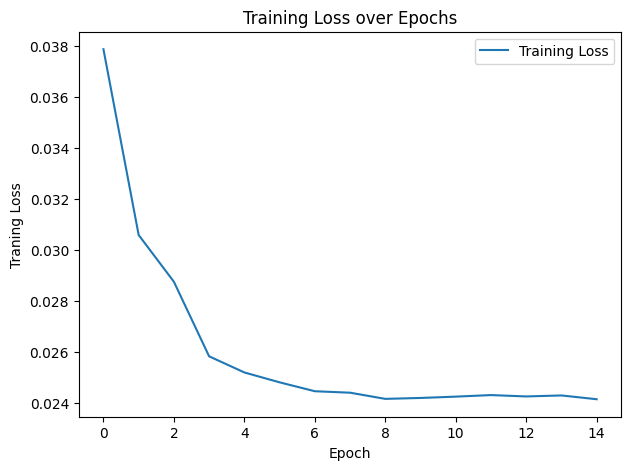

In [38]:
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Traning Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

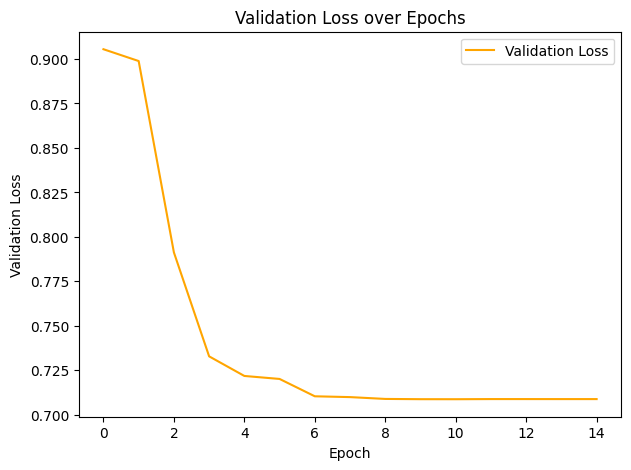

In [39]:
plt.figure(figsize=(7, 5))
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Epochs")
plt.legend()
plt.show()

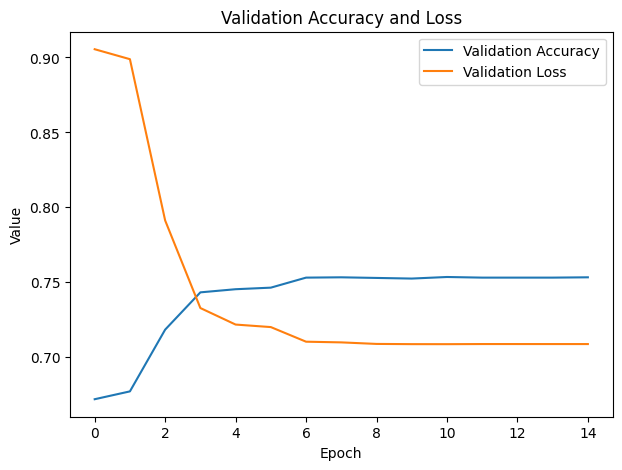

In [40]:
plt.figure(figsize=(7, 5))
plt.plot(val_accs, label="Validation Accuracy")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Validation Accuracy and Loss")
plt.legend()
plt.show()

In [27]:
def evaluate_model(trained_model, test_loader):
    model.eval()
    correct = 0
    total = 0
        
    with torch.inference_mode():
              
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            
            _, preds = torch.max(logits, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        
    test_acc = correct / total
        
    print(f"Test Accuracy: {test_acc*100:.4f}%")

In [28]:
evaluate_model(trained_model, test_dl)

Test Accuracy: 74.7283%
